In this notebook we project both EGFR and Abl snapshots onto the same tICA space and compare their marginal distributions. 

In [1]:
import sys, os
from pathlib import Path
from addict import Dict as Adict
import pandas as pd
from pathlib import Path
from natsort import natsorted

sys.path.insert(0, '/home/rzhu/Desktop/projects/kinase_analysis/src/')

from MSMAnalysis import *
import mdtraj as md
from funcs_featurise import *
from funcs_db_assign import *
from funcs_plotting import *
from funcs_sample import *

In [2]:
plt.rcParams['xtick.labelsize'] = 14  # Font size for x-tick labels
plt.rcParams['ytick.labelsize'] = 14  # Font size for y-tick labels
plt.rcParams['legend.fontsize'] = 16  # Font size for legend
plt.rcParams['axes.labelsize'] = 18   # Font size for x-label and y-label

Load trajectories into the same MSMAnalysis object. Here we are not including the activation loop features due to the restriction of RAM.  

In [3]:
features = ['dbdist', 'dbdihed', 'achelix']

In [4]:
base_path = Path('/home/rzhu/Desktop/projects/kinase_analysis/')

MA = MSMAnalysis('abl_egfr', trajlen_cutoff=1000)
MA.load_ftrajs(names=features, 
               arc_dir=base_path/'data'/'abl'/'ftrajs', 
               features=[s+'_abl' for s in features])

Loading feature:  dbdist_abl


  3%|▎         | 23/749 [00:00<00:03, 224.65it/s]

100%|██████████| 749/749 [00:04<00:00, 158.15it/s]


Loading feature:  dbdihed_abl


100%|██████████| 749/749 [00:06<00:00, 123.12it/s]


Loading feature:  achelix_abl


100%|██████████| 749/749 [00:04<00:00, 154.94it/s]

Features loaded: {'dbdist_abl', 'achelix_abl', 'dbdihed_abl'}


In [5]:
MA.load_ftrajs(names=features, 
               arc_dir=base_path/'data'/'egfr'/'ftrajs', 
               features=[s+'_egfr' for s in features])

Loading feature:  dbdist_egfr


100%|██████████| 3472/3472 [00:00<00:00, 10366.02it/s]


Loading feature:  dbdihed_egfr


100%|██████████| 3472/3472 [00:00<00:00, 4429.23it/s]


Loading feature:  achelix_egfr


100%|██████████| 3472/3472 [00:00<00:00, 10088.09it/s]

Features loaded: {'achelix_abl', 'dbdihed_egfr', 'dbdihed_abl', 'dbdist_egfr', 'dbdist_abl', 'achelix_egfr'}


In [6]:
hp_dict = Adict({'tica__lag': 10,
                'tica__stride': 100,
                'tica__dim': 20,
                'cluster__k': 1000,
                'cluster__stride': 1000,
                'cluster__maxiter': 1000,
                'markov__lag': 100})

Prepare abl & egfr ftrajs separately. 

In [7]:
abl_ftrajs = MA.select_ftrajs([s+'_abl' for s in features])
abl_ftrajs, mapping = prepare_ftrajs(abl_ftrajs, len_cutoff=MA._trajlen_cutoff)

TypeError: prepare_ftrajs() got an unexpected keyword argument 'stride'

In [9]:
egfr_ftrajs = MA.select_ftrajs([s+'_egfr' for s in features])
egfr_ftrajs, mapping = prepare_ftrajs(egfr_ftrajs, len_cutoff=MA._trajlen_cutoff)

TypeError: prepare_ftrajs() got an unexpected keyword argument 'stride'

In [ ]:
study = MSMStudy('compare_projection', 
                 ftrajs = abl_ftrajs + egfr_ftrajs,
                 mapping=None,
                 wk_dir=Path('/home/rzhu/Desktop/projects/kinase_analysis/data/co-projection/'),
                 **hp_dict)

NameError: name 'egfr_ftrajs' is not defined

Compute a tica model using concatenated ftrajs. Transform abl and egfr ftrajs respectively. 

In [9]:
from pyemma.coordinates import tica

tica_mod = tica(abl_ftrajs + egfr_ftrajs, 
                lag=hp_dict.tica__lag, 
                dim=hp_dict.tica__dim, 
                stride=hp_dict.tica__stride)
abl_ttrajs = tica_mod.transform(abl_ftrajs)
egfr_ttrajs = tica_mod.transform(egfr_ftrajs)

ttraj_all = np.concatenate(abl_ttrajs + egfr_ttrajs)
abl_cat_ttrajs = np.concatenate(abl_ttrajs)
egfr_cat_ttrajs = np.concatenate(egfr_ttrajs)

/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|██████████| 2417/2417 [00:00<00:00, 2586.68it/s]                       


Perform clustering on abl and egfr ttrajs respectively. Plot the cluster centers on the same tICA space. 

In [10]:
from pyemma.coordinates import cluster_kmeans

abl_kmeans_mod = cluster_kmeans(abl_ttrajs, k=hp_dict.cluster__k, stride=hp_dict.cluster__stride, max_iter=hp_dict.cluster__maxiter, fixed_seed=42)
egfr_kmeans_mod = cluster_kmeans(egfr_ttrajs, k=hp_dict.cluster__k, stride=hp_dict.cluster__stride, max_iter=hp_dict.cluster__maxiter, fixed_seed=42)

/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
100%|██████████| 1000/1000 [00:00<00:00, 1984.28it/s]
/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
100%|██████████| 1000/1000 [00:03<00:00, 275.77it/s]


In [196]:
MA.load_ftrajs(names=['distgroup', 'dihedgroup'], 
               arc_dir=base_path/'data'/'abl'/'ftrajs', 
               features=['distgroup_abl','dihedgroup_abl'])
MA.load_ftrajs(names=['distgroup', 'dihedgroup'], 
               arc_dir=base_path/'data'/'egfr'/'ftrajs', 
               features=['distgroup_egfr','dihedgroup_egfr'])

Feature distgroup_abl already loaded. Skipping...
Feature dihedgroup_abl already loaded. Skipping...
Features loaded: {'dihedgroup_abl', 'dbdist_abl', 'dbdist_egfr', 'dbdihed_abl', 'dbdihed_egfr', 'achelix_abl', 'achelix_egfr', 'distgroup_abl'}
Loading feature:  distgroup_egfr


100%|██████████| 3472/3472 [00:00<00:00, 13157.07it/s]


Loading feature:  dihedgroup_egfr


100%|██████████| 3472/3472 [00:00<00:00, 12117.64it/s]

Features loaded: {'dihedgroup_abl', 'dbdist_abl', 'distgroup_egfr', 'dbdist_egfr', 'dbdihed_abl', 'dbdihed_egfr', 'dihedgroup_egfr', 'achelix_abl', 'achelix_egfr', 'distgroup_abl'}


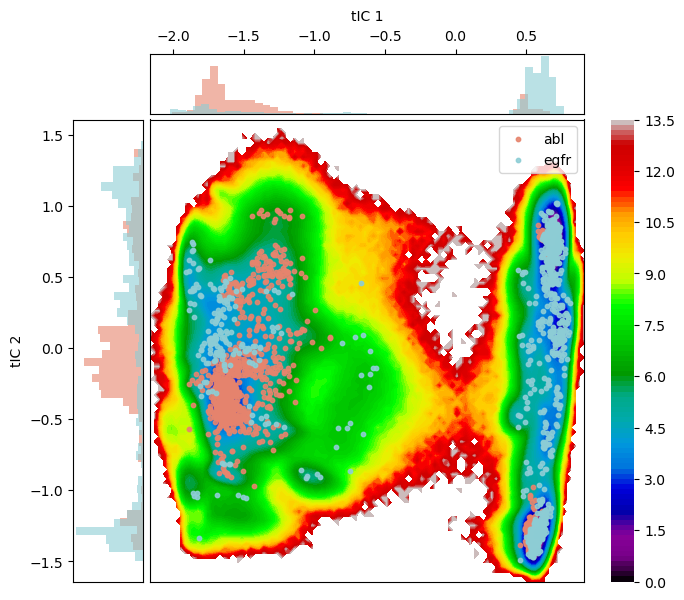

In [78]:
fig, ax = plt.subplots(figsize=(7, 6))

ax, contour, cbar = plot_energy2d(energy2d(ttraj_all[:, 0], ttraj_all[:, 1]), ax=ax, contourf_kws=dict(cmap='nipy_spectral'))

intx_ax = fig.add_axes([ax.get_position().x0, ax.get_position().y1 + 0.01,
                        ax.get_position().width, 0.10])
inty_ax = fig.add_axes([ax.get_position().x0 - 0.11, ax.get_position().y0,
                        0.10, ax.get_position().height])

ax.scatter(abl_kmeans_mod.cluster_centers_[:, 0], abl_kmeans_mod.cluster_centers_[:, 1], s=10, c='#E6846D', alpha=0.9, marker='o', label='abl')
ax.scatter(egfr_kmeans_mod.cluster_centers_[:, 0], egfr_kmeans_mod.cluster_centers_[:, 1], s=10, c='#8DCDD5', alpha=0.9, marker='o', label='egfr')
ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

intx_ax.hist(abl_kmeans_mod.cluster_centers_[:, 0], bins=50, color='#E6846D', alpha=0.6, orientation='vertical')
intx_ax.hist(egfr_kmeans_mod.cluster_centers_[:, 0], bins=50, color='#8DCDD5', alpha=0.6, orientation='vertical')
inty_ax.hist(abl_kmeans_mod.cluster_centers_[:, 1], bins=50, color='#E6846D', alpha=0.6, orientation='horizontal')
inty_ax.hist(egfr_kmeans_mod.cluster_centers_[:, 1], bins=50, color='#8DCDD5', alpha=0.6, orientation='horizontal')

intx_ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False, top=True, labeltop=True)
inty_ax.tick_params(bottom=False, left=True, labelbottom=False, labelleft=True)
inty_ax.xaxis.set_inverted(True)
intx_ax.set_xlabel('tIC 1', labelpad=-75)
inty_ax.set_ylabel('tIC 2')

legend = ax.legend()

plt.savefig(study.fig_dir/'coprojection_abl-egfr.png', transparent=True, bbox_inches='tight', dpi=300)
plt.show()

What features have contributed the most to the frist two tICs?

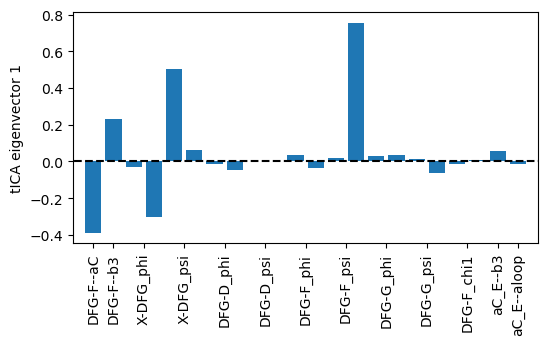

In [64]:
fig, ax = plt.subplots(figsize=(6, 3))

ax.bar(x=np.arange(0, 22), height=tica_mod.eigenvectors[:, 0])
ax.hlines(0, ax.get_xlim()[0], ax.get_xlim()[1], color='black', linestyle='--')
ax.set_xlim(-1, 22)

ax.set_xticks([0, 1, 2.5, 4.5, 6.5, 8.5, 10.5, 12.5, 14.5, 16.5, 18.5, 20, 21])
ax.set_xticklabels(['DFG-F--aC',
                    'DFG-F--b3',
                    'X-DFG_phi',
                    'X-DFG_psi',
                    'DFG-D_phi',
                    'DFG-D_psi',
                    'DFG-F_phi',
                    'DFG-F_psi',
                    'DFG-G_phi',
                    'DFG-G_psi',
                    'DFG-F_chi1',
                    'aC_E--b3',
                    'aC_E--aloop'], 
                   rotation=90)
ax.set_ylabel('tICA eigenvector 1')

plt.savefig(study.fig_dir/'coprojection_tIC1_contributions.png', transparent=True, bbox_inches='tight', dpi=300)
plt.show()

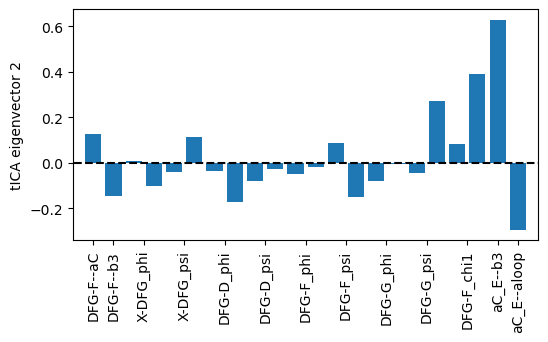

In [65]:
fig, ax = plt.subplots(figsize=(6, 3))

ax.bar(x=np.arange(0, 22), height=tica_mod.eigenvectors[:, 1])
ax.hlines(0, ax.get_xlim()[0], ax.get_xlim()[1], color='black', linestyle='--')
ax.set_xlim(-1, 22)

ax.set_xticks([0, 1, 2.5, 4.5, 6.5, 8.5, 10.5, 12.5, 14.5, 16.5, 18.5, 20, 21])
ax.set_xticklabels(['DFG-F--aC',
                    'DFG-F--b3',
                    'X-DFG_phi',
                    'X-DFG_psi',
                    'DFG-D_phi',
                    'DFG-D_psi',
                    'DFG-F_phi',
                    'DFG-F_psi',
                    'DFG-G_phi',
                    'DFG-G_psi',
                    'DFG-F_chi1',
                    'aC_E--b3',
                    'aC_E--aloop'], 
                   rotation=90)
ax.set_ylabel('tICA eigenvector 2')

plt.savefig(study.fig_dir/'coprojection_tIC2_contributions.png', transparent=True, bbox_inches='tight', dpi=300)
plt.show()

In [81]:
abl_dist_assignments, mapping = prepare_ftrajs(MA.select_ftrajs(['distgroup_abl']), stride=1, len_cutoff=MA._trajlen_cutoff)
abl_dihed_assignments, mapping = prepare_ftrajs(MA.select_ftrajs(['dihedgroup_abl']), stride=1, len_cutoff=MA._trajlen_cutoff)
cat_abl_dist_assignments = np.concatenate([traj.flatten() for traj in abl_dist_assignments])
cat_abl_dihed_assignments = np.concatenate([traj.flatten() for traj in abl_dihed_assignments])

Preparing feature trajectories...


100%|██████████| 749/749 [00:00<00:00, 12371.46it/s]


Preparing feature trajectories...


100%|██████████| 749/749 [00:00<00:00, 34557.67it/s]


In [197]:
egfr_dist_assignments, mapping = prepare_ftrajs(MA.select_ftrajs(['distgroup_egfr']), stride=1, len_cutoff=MA._trajlen_cutoff)
egfr_dihed_assignments, mapping = prepare_ftrajs(MA.select_ftrajs(['dihedgroup_egfr']), stride=1, len_cutoff=MA._trajlen_cutoff)
cat_egfr_dist_assignments = np.concatenate([traj.flatten() for traj in egfr_dist_assignments])
cat_egfr_dihed_assignments = np.concatenate([traj.flatten() for traj in egfr_dihed_assignments])

Preparing feature trajectories...


100%|██████████| 3472/3472 [00:00<00:00, 25449.34it/s]


Preparing feature trajectories...


100%|██████████| 3472/3472 [00:00<00:00, 27947.11it/s]


In [101]:
dist_group_colours = np.array([
                            (173/255, 35/255, 10/255),  # Red
                            (28/225, 128/255, 65/255),  # Green
                            (80/255, 29/255, 138/255)])  # Purple

In [103]:
outer_colors = np.array([
    (128/255, 128/255, 128/255),  # Gray
    (235/255, 95/255, 70/255),    # Light Red
    (240/255, 146/255, 58/255),   # Flamebright
    (255/255, 214/255, 92/255),   # Light yellow
    (255/255, 188/255, 214/255),  # Light pink
    (210/255, 180/255, 140/255),  # Tan
    (196/255, 79/255, 108/255),   # Strawberry
    (128/255, 128/255, 128/255),  # Gray
    (25/255, 189/255, 85/255),    # Light Green
    (128/255, 128/255, 128/255),  # Gray
    (136/255, 75/255, 204/255)])   # Light Purple

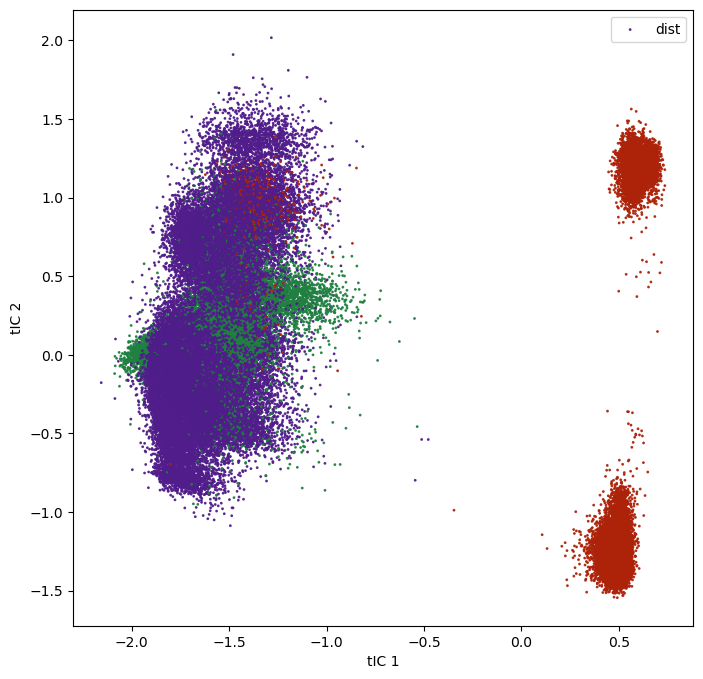

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
fes_cmap='nipy_spectral'
#ax, contour, cbar = plot_energy2d(energy2d(ttraj_all[:, 0], ttraj_all[:, 1]), ax=ax, contourf_kws=dict(cmap=fes_cmap))

#ax.scatter(abl_kmeans_mod.clustercenters[:,0], abl_kmeans_mod.clustercenters[:,1], s=5, label='abl')
#ax.scatter(egfr_kmeans_mod.clustercenters[:,0], egfr_kmeans_mod.clustercenters[:,1], s=5, label='egfr')

ax.scatter(abl_cat_ttrajs[::100,0], abl_cat_ttrajs[::100,1], c=dist_group_colours[cat_abl_dist_assignments[::100],:], s=1, alpha=0.9, label='dist')

ax.set_xlabel('tIC 1')
ax.set_ylabel('tIC 2')
ax.legend()
plt.show()

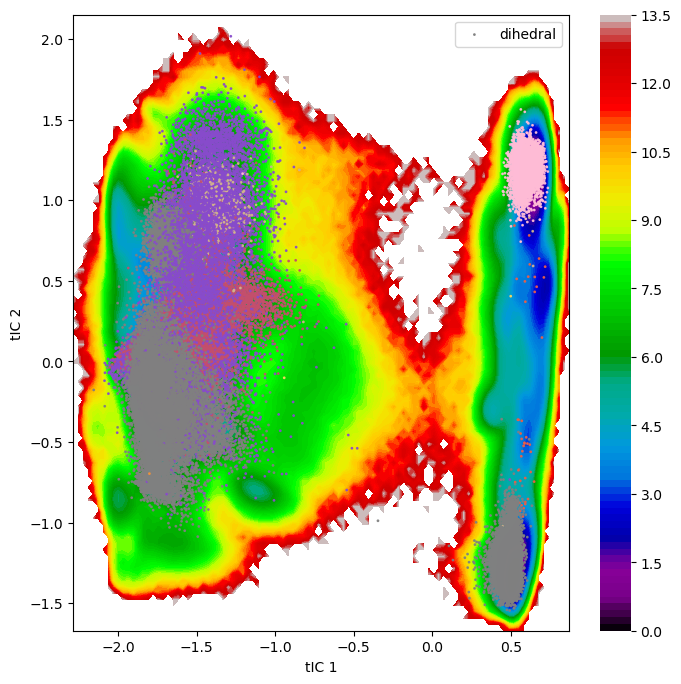

In [112]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
fes_cmap='nipy_spectral'
ax, contour, cbar = plot_energy2d(energy2d(ttraj_all[:, 0], ttraj_all[:, 1]), ax=ax, contourf_kws=dict(cmap=fes_cmap))

#ax.scatter(abl_kmeans_mod.clustercenters[:,0], abl_kmeans_mod.clustercenters[:,1], s=5, l

abel='abl'
#ax.scatter(egfr_kmeans_mod.clustercenters[:,0], egfr_kmeans_mod.clustercenters[:,1], s=5, label='egfr')

ax.scatter(abl_cat_ttrajs[::100,0], abl_cat_ttrajs[::100,1], c=outer_colors[cat_abl_dihed_assignments[::100],:], s=1, alpha=0.9, label='dihedral')

ax.set_xlabel('tIC 1')
ax.set_ylabel('tIC 2')
ax.legend()
plt.show()

In [212]:
import seaborn as sns

dim = hp_dict.tica__dim
palette = {'abl_DFG_in': dist_group_colours[0], 'abl_DFG_inter': dist_group_colours[1], 'abl_DFG_out': dist_group_colours[2],
               'egfr_DFG_in': dist_group_colours[0], 'egfr_DFG_inter': dist_group_colours[1], 'egfr_DFG_out': dist_group_colours[2]}
linestyles = [':',':',':','-','-','-']

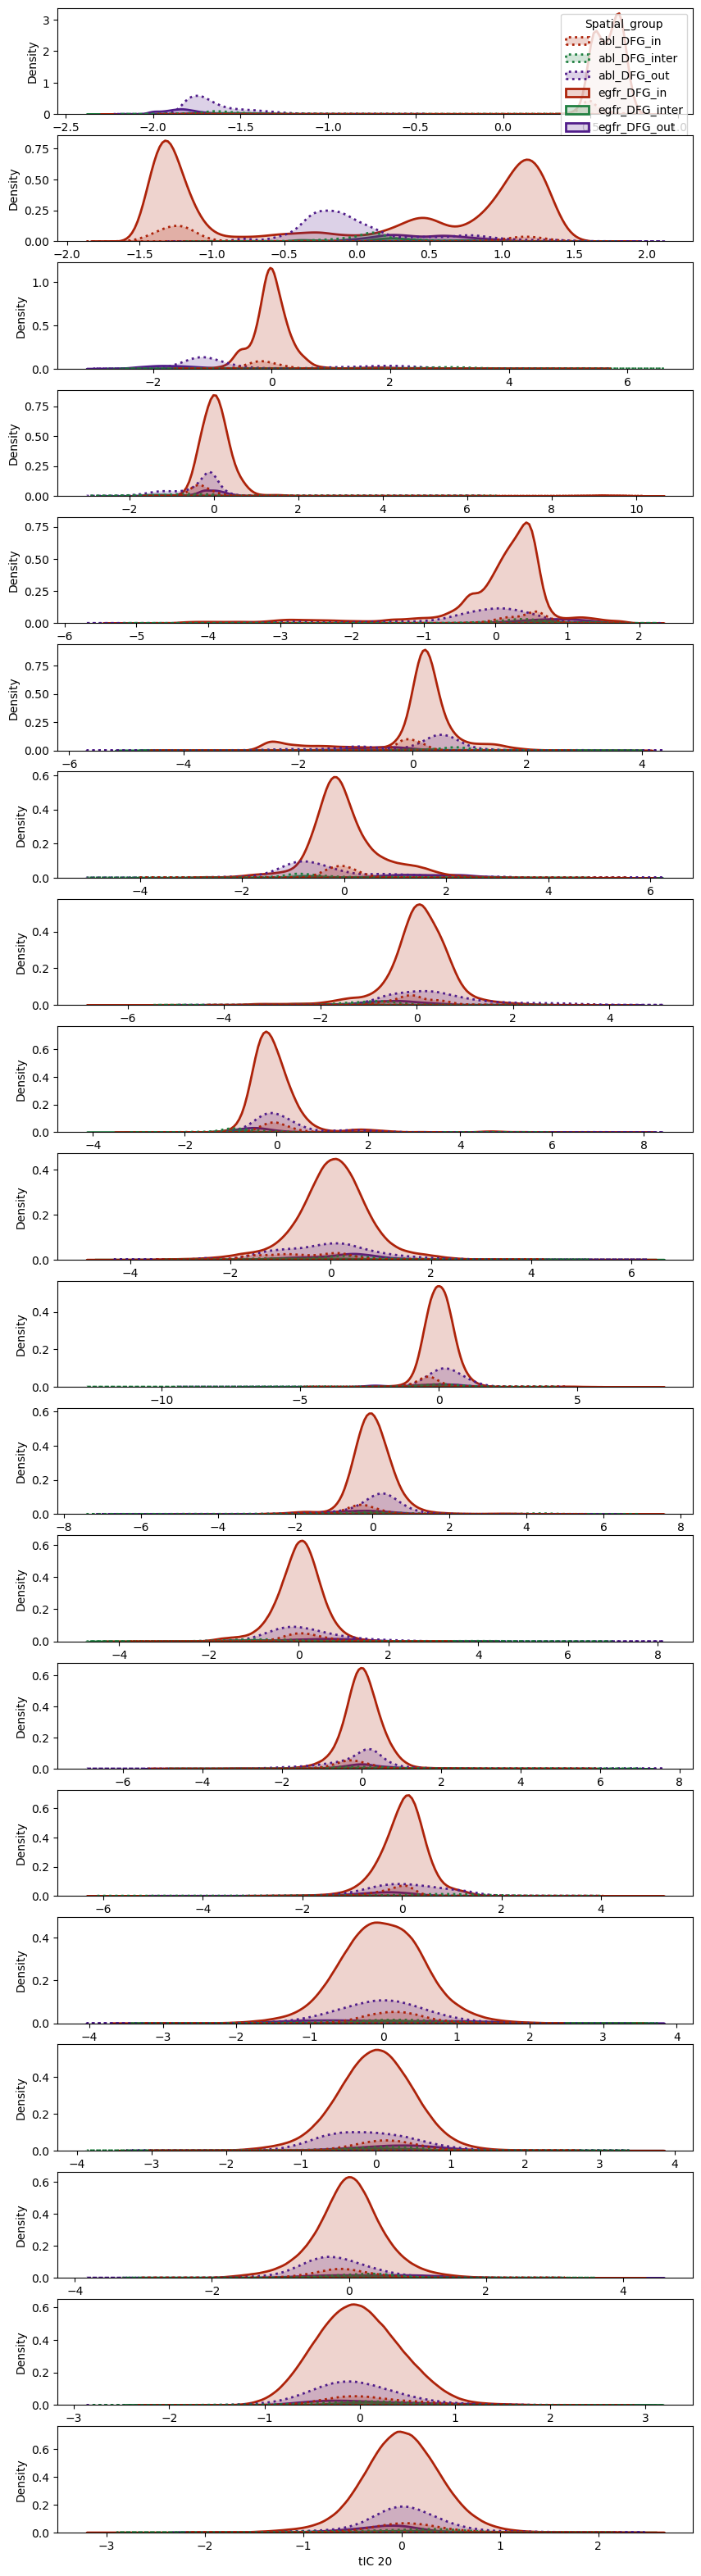

In [220]:
fig, axes = plt.subplots(dim, 1, figsize=(10, dim*2))

for i in range(dim):
    ttraj_df = []
    ttraj_df.append(pd.DataFrame({'Value': abl_cat_ttrajs[cat_abl_dist_assignments==0][::10,i], 'Spatial_group': 'abl_DFG_in'}))
    ttraj_df.append(pd.DataFrame({'Value': abl_cat_ttrajs[cat_abl_dist_assignments==1][::10,i], 'Spatial_group': 'abl_DFG_inter'}))
    ttraj_df.append(pd.DataFrame({'Value': abl_cat_ttrajs[cat_abl_dist_assignments==2][::10,i], 'Spatial_group': 'abl_DFG_out'}))

    ttraj_df.append(pd.DataFrame({'Value': egfr_cat_ttrajs[cat_egfr_dist_assignments==0][::10,i], 'Spatial_group': 'egfr_DFG_in'}))
    ttraj_df.append(pd.DataFrame({'Value': egfr_cat_ttrajs[cat_egfr_dist_assignments==1][::10,i], 'Spatial_group': 'egfr_DFG_inter'}))
    ttraj_df.append(pd.DataFrame({'Value': egfr_cat_ttrajs[cat_egfr_dist_assignments==2][::10,i], 'Spatial_group': 'egfr_DFG_out'}))
    combined_data = pd.concat(ttraj_df)
    
    p = sns.kdeplot(data=combined_data, x='Value', hue='Spatial_group', ax=axes[i],
                    palette=palette, lw=2, alpha=0.2, fill=True)
    
    handles = p.legend_.legend_handles[::-1]

    for j, (line, handle) in enumerate(zip(p.collections, handles)):
        line.set_linestyle(linestyles[j])
        handle.set_ls(linestyles[j])

    axes[i].set_xlabel(f'tIC {i+1}')
    axes[i].set_ylabel('Density')

    if i > 0:
        axes[i].legend_.remove()

plt.savefig(study.fig_dir/'marginal_distributions.png', transparent=True, bbox_inches='tight', dpi=300)
plt.show()